In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import random
import seaborn as sns
import tqdm

import gp_aug
import regressor
import utils

import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.size'] = 15

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import model_selection

torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)
random.seed(123)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

plt.rcParams['font.size'] = 15

In [2]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}
passband2color = {
    0: 'blue', 2: 'green', 4: 'purple',
    1: 'orange', 3: 'red', 5: 'brown'
}

In [3]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

def compile_obj(t, flux, flux_err, passband):
    obj = pd.DataFrame()
    obj['mjd']      = t
    obj['flux']     = flux
    obj['flux_err'] = flux_err
    obj['passband'] = passband
    return obj

def is_good(anobject, peak_mjd):
    if peak_mjd < anobject['mjd'].min() or peak_mjd > anobject['mjd'].max():
        return False
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        return False
    
    # keep only objects with at least 5 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 5:
            count += 1
    if count > 3:
        return False
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        return False
    
    return True

def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best',fontsize=14)
    plt.title(title, size=14)

In [4]:
def residuals_histogram(all_objects):
    plt.figure(figsize=(10, 7))
    plt.hist(all_objects['true_peakmjd'].values - all_objects['pred_peakmjd'].values, bins=50)
    plt.xlabel('mjd residuals', fontsize=15)
    plt.show()
    
def several_residuals_hist_boxplot(dfs, names, bins=100):
    plt.figure(figsize=(13, 12))
    plt.subplot(2, 1, 1)
    metrics = np.array([
        df['true_peakmjd'].values - df['pred_peakmjd'].values for df in dfs
    ])
    gen_bins = np.linspace(-1.1 * np.max(np.abs(metrics)),
                       1.1 * np.max(np.abs(metrics)), bins)
    for metric, name in zip(metrics, names):
        plt.hist(metric, bins=gen_bins,
                 alpha=1/len(dfs), label=name)
    plt.xlabel('mjd residuals', fontsize=15)
    plt.legend()
    plt.grid()
    
    left, right = plt.xlim()
    
    new_df = pd.DataFrame({
        name: df['true_peakmjd'].values - df['pred_peakmjd'].values for name, df in zip(names, dfs)
    })
    new_df = pd.melt(new_df).rename({'variable': 'algorithm', 'value': 'mjd residuals'}, axis=1)
    
    plt.subplot(2, 1, 2)
    sns.boxplot(data=new_df, x='mjd residuals', y='algorithm')
    plt.xlim(left, right)
    plt.grid()
    
    plt.show()

In [5]:
def train_epoch(model, opt, loss_func, loader):
    model.train()
    running_loss = 0
    n_batches = 0
    for x, y in loader:
        pred = model(x.to(device).float()).view(-1)
        loss = loss_func(pred, y.to(device).float())
        
        opt.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        opt.step()
        
        running_loss += loss.item()
        n_batches += 1
    return running_loss / n_batches

def eval_epoch(model, loss_func, loader):
    model.eval()
    running_loss = 0
    n_batches = 0
    with torch.no_grad():
        for x, y in loader:
            pred = model(x.to(device).float()).view(-1)
            loss = loss_func(pred, y.to(device).float())

            running_loss += loss.item()
            n_batches += 1
    return running_loss / n_batches

def train_eval(model, opt, sched, loss_func, train_loader, val_loader, n_epoch, verbose=False):
    best_state = None
    best_val_loss = 1e300
    
    train_hist = []
    val_hist = []
    for epoch in range(n_epoch):
        train_loss = train_epoch(model, opt, loss_func, train_loader)
        val_loss = eval_epoch(model, loss_func, val_loader)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
        
        if verbose:
            print(f"Epoch {epoch+1}, train MSE {train_loss:.4}, val MSE {val_loss:.4}")
        
        train_hist.append(train_loss)
        val_hist.append(val_loss)
        
        sched.step()
    
    model.load_state_dict(best_state)
    model.eval()
    return train_hist, val_hist

GP


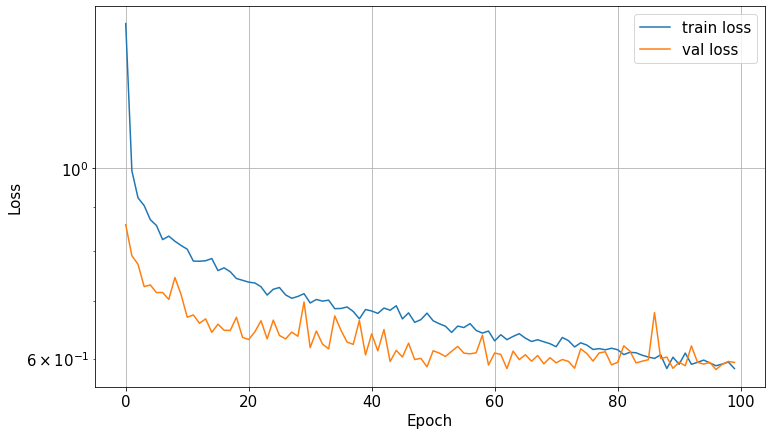

	CNN		Direct
RMSE:	4.494		11.14
MAE:	2.645		7.319
RSE:	0.01603		0.03973
RAE:	0.01062		0.02939
MAPE:	0.004393	0.01216
MLP


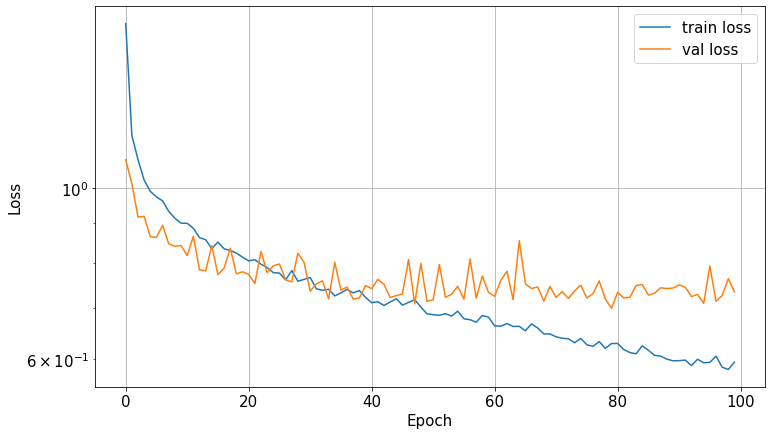

	CNN		Direct
RMSE:	5.715		15.66
MAE:	3.306		8.639
RSE:	0.02039		0.05586
RAE:	0.01328		0.03469
MAPE:	0.005491	0.01436
NN


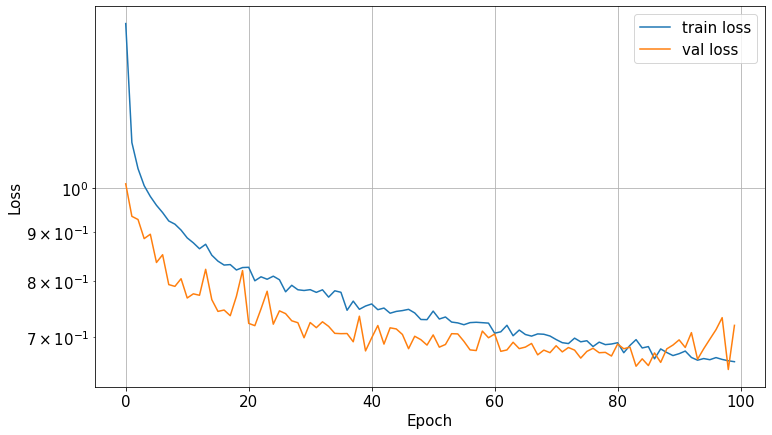

	CNN		Direct
RMSE:	5.592		12.64
MAE:	3.241		8.392
RSE:	0.01995		0.04508
RAE:	0.01302		0.0337
MAPE:	0.005385	0.01394
FE


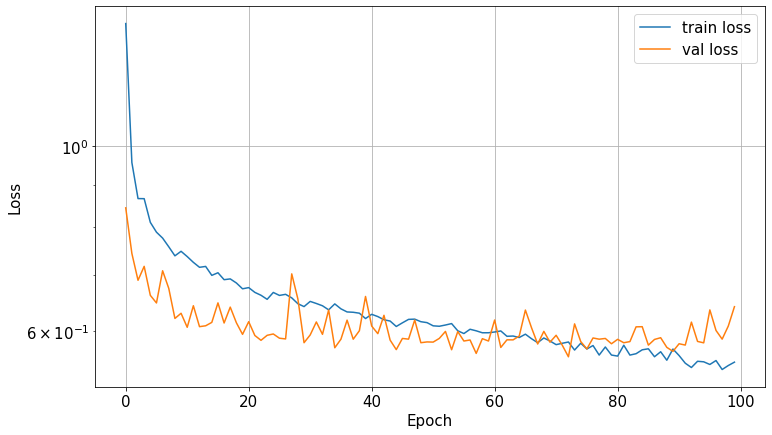

	CNN		Direct
RMSE:	4.688		10.15
MAE:	2.589		7.152
RSE:	0.01672		0.03622
RAE:	0.0104		0.02872
MAPE:	0.004302	0.01189
RBF


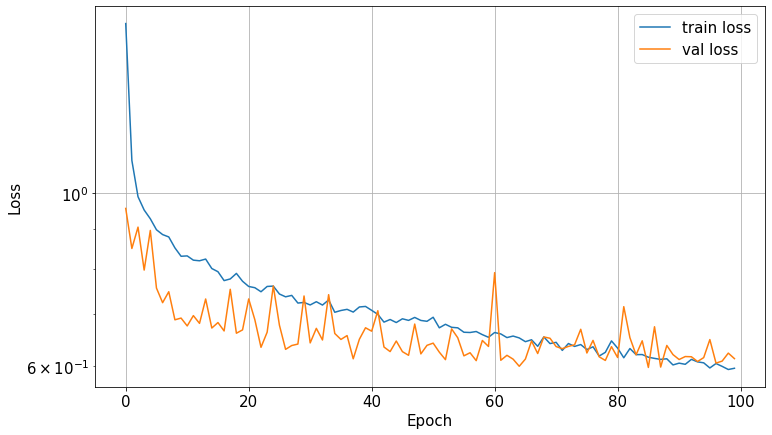

	CNN		Direct
RMSE:	4.868		11.91
MAE:	2.908		7.911
RSE:	0.01737		0.04248
RAE:	0.01168		0.03177
MAPE:	0.004831	0.01315


In [6]:
results = {}
for name in ['GP', 'MLP', 'NN', 'FE', 'RBF']:
    print(name)
    pictures = np.load(f'cnn_cls_data/{name}_pictures_128.npy')
    timestamps = np.load(f'cnn_cls_data/{name}_timestamps_128.npy')[:, [0, -1]]  # only the first and the last timestamps
    true_peaks = np.load(f'cnn_cls_data/{name}_true_peaks_128.npy')

    trainval_pics, test_pics, trainval_ts, test_ts, trainval_tp, test_tp = \
        model_selection.train_test_split(pictures, timestamps, true_peaks, test_size=0.2, random_state=42)
    train_pics, val_pics, train_ts, val_ts, train_tp, val_tp = \
        model_selection.train_test_split(trainval_pics, trainval_ts, trainval_tp, test_size=0.2, random_state=42)

    train_X = train_pics
    train_y = (train_tp - train_ts[:, 0]) / (train_ts[:, -1] - train_ts[:, 0])
    train_y = np.log(train_y / (1 - train_y))

    val_X = val_pics
    val_y = (val_tp - val_ts[:, 0]) / (val_ts[:, -1] - val_ts[:, 0])
    val_y = np.log(val_y / (1 - val_y))

    test_X = test_pics
    test_y = (test_tp - test_ts[:, 0]) / (test_ts[:, -1] - test_ts[:, 0])
    test_y = np.log(test_y / (1 - test_y))

    train_ds = torch.utils.data.TensorDataset(torch.tensor(train_X), 
                                              torch.tensor(train_y))
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)

    val_ds = torch.utils.data.TensorDataset(torch.tensor(val_X), 
                                            torch.tensor(val_y))
    val_dl = torch.utils.data.DataLoader(val_ds, batch_size=8, shuffle=False)

    test_ds = torch.utils.data.TensorDataset(torch.tensor(test_X), 
                                             torch.tensor(test_y))
    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=8, shuffle=False)

    device = torch.device('cuda:0')
    model = nn.Sequential(
        nn.Conv1d(6, 8, 3, padding=1),
        nn.LayerNorm((8, 128)),
        nn.ReLU(),
        nn.Conv1d(8, 16, 3, padding=1),
        nn.LayerNorm((16, 128)),
        nn.ReLU(),
        nn.MaxPool1d(4),
        nn.Conv1d(16, 32, 3, padding=1),
        nn.LayerNorm((32, 32)),
        nn.ReLU(),
        nn.MaxPool1d(2),
        nn.Flatten(),
        nn.Dropout(0.33),
        nn.Linear(16 * 32, 1)
    ).to(device)
    opt = torch.optim.Adam(model.parameters(), 3e-4)
    sched = torch.optim.lr_scheduler.StepLR(opt, 100)
    loss_func = nn.MSELoss()

    result = train_eval(model, opt, sched, loss_func, train_dl, val_dl, 100)

    plt.figure(figsize=(12, 7))
    plt.semilogy(result[0], label='train loss')
    plt.semilogy(result[1], label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()

    torch.save(model.state_dict(), f'cnn_cls_data/{name}_cnn_128.pt')
    
    test_gt = []
    test_pred = []

    for batch_x, batch_y in test_dl:
        batch_pred = model(batch_x.to(device).float()).view(-1).cpu().detach().numpy()
        test_pred.extend(batch_pred)
        test_gt.extend(batch_y.detach().numpy())

    test_gt = 1 / (1 + np.exp(-np.array(test_gt)))
    test_gt = test_gt * (test_ts[:, -1] - test_ts[:, 0]) + test_ts[:, 0]
    test_pred = 1 / (1 + np.exp(-np.array(test_pred)))
    test_pred = test_pred * (test_ts[:, -1] - test_ts[:, 0]) + test_ts[:, 0]
    result_df = pd.DataFrame({
        'true_peakmjd': test_gt,
        'pred_peakmjd': test_pred
    })

    direct_pred = []
    for batch_x, _ in test_dl:
        batch_x = batch_x.detach().numpy().sum(axis=1).argmax(axis=1) / (batch_x.shape[-1] - 1)
        direct_pred.extend(batch_x)
    direct_pred = np.array(direct_pred) * (test_ts[:, -1] - test_ts[:, 0]) + test_ts[:, 0]
    direct_result_df = pd.DataFrame({
        'true_peakmjd': test_gt,
        'pred_peakmjd': direct_pred
    })
    
    results[name] = (result_df, direct_result_df)
    
    [rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(result_df['true_peakmjd'].values, 
                                                                          result_df['pred_peakmjd'].values)
    [rmse_dir, mae_dir, rse_dir, rae_dir, mape_dir] = \
        utils.regression_quality_metrics_report(direct_result_df['true_peakmjd'].values, 
                                                direct_result_df['pred_peakmjd'].values)

    print("\tCNN\t\tDirect")
    print("RMSE:\t{:.4}\t\t{:.4}".format(rmse, rmse_dir))
    print("MAE:\t{:.4}\t\t{:.4}".format(mae, mae_dir))
    print("RSE:\t{:.4}\t\t{:.4}".format(rse, rse_dir))
    print("RAE:\t{:.4}\t\t{:.4}".format(rae, rae_dir))
    print("MAPE:\t{:.4}\t{:.4}".format(mape, mape_dir))

In [8]:
def regression_quality_metrics_report_bs(true, pred, samples=10000):
    assert len(true) == len(pred)
    mask = np.random.randint(0, len(true), (samples, len(true)))
    reports = []
    for mask_row in mask:
        reports.append(
            utils.regression_quality_metrics_report(true[mask_row], pred[mask_row])
        )
    reports = np.array(reports)
    return reports.mean(axis=0), reports.std(axis=0, ddof=1)

In [16]:
metric_df = pd.DataFrame()
for name, (res, direct_res) in results.items():
    
    cnn_metrics, cnn_std = map(list, regression_quality_metrics_report_bs(
        res['true_peakmjd'].values, res['pred_peakmjd'].values))
    
    dir_metrics, dir_std = map(list, regression_quality_metrics_report_bs(
        direct_res['true_peakmjd'].values, direct_res['pred_peakmjd'].values))  
    
    metric_df[name] = cnn_metrics + cnn_std + dir_metrics + dir_std

metric_df.index = ['CNN_RMSE_mean', 'CNN_MAE_mean', 'CNN_RSE_mean', 'CNN_RAE_mean', 'CNN_MAPE_mean',
                   'CNN_RMSE_std', 'CNN_MAE_std', 'CNN_RSE_std', 'CNN_RAE_std', 'CNN_MAPE_std',
                   'Direct_RMSE_mean', 'Direct_MAE_mean', 'Direct_RSE_mean', 'Direct_RAE_mean', 'Direct_MAPE_mean',
                   'Direct_RMSE_std', 'Direct_MAE_std', 'Direct_RSE_std', 'Direct_RAE_std', 'Direct_MAPE_std']
metric_df.index = pd.MultiIndex.from_tuples([x.split('_') for x in metric_df.index]).reorder_levels((1, 0, 2))
metric_df = metric_df.sort_index().unstack(level=2)
metric_df = metric_df.iloc[[6, 7, 0, 1, 8, 9, 4, 5, 2, 3], :]
metric_df.round(5)

GP                MLP                 NN           \
                 mean      std      mean      std      mean      std   
RMSE CNN      4.49000  0.19522   5.70439  0.28491   5.58813  0.24737   
     Direct  11.13241  0.40081  15.63365  0.78335  12.63328  0.55084   
MAE  CNN      2.64439  0.07726   3.30422  0.09808   3.24175  0.09670   
     Direct   7.32077  0.17649   8.64082  0.27394   8.39643  0.20240   
RSE  CNN      0.01602  0.00071   0.02036  0.00103   0.01994  0.00090   
     Direct   0.03973  0.00148   0.05579  0.00285   0.04509  0.00202   
RAE  CNN      0.01062  0.00033   0.01327  0.00042   0.01302  0.00041   
     Direct   0.02941  0.00079   0.03471  0.00118   0.03374  0.00091   
MAPE CNN      0.00439  0.00013   0.00549  0.00016   0.00539  0.00016   
     Direct   0.01217  0.00029   0.01436  0.00046   0.01395  0.00034   

                   FE                RBF           
                 mean      std      mean      std  
RMSE CNN      4.67650  0.37388   4.86484  0.21825  
     Direct  10.14206  0.41637  11.90062  0.43361  
MAE  CNN      2.58948  0.08407   2.90891  0.08372  
     Direct   7.15228  0.15209   7.91148  0.18919  
RSE  CNN      0.01669  0.00135   0.01736  0.00079  
     Direct   0.03620  0.00152   0.04247  0.00159  
RAE  CNN      0.01040  0.00036   0.01169  0.00036  
     Direct   0.02874  0.00071   0.03179  0.00085  
MAPE CNN      0.00430  0.00014   0.00483  0.00014  
     Direct   0.01189  0.00025   0.01315  0.00031

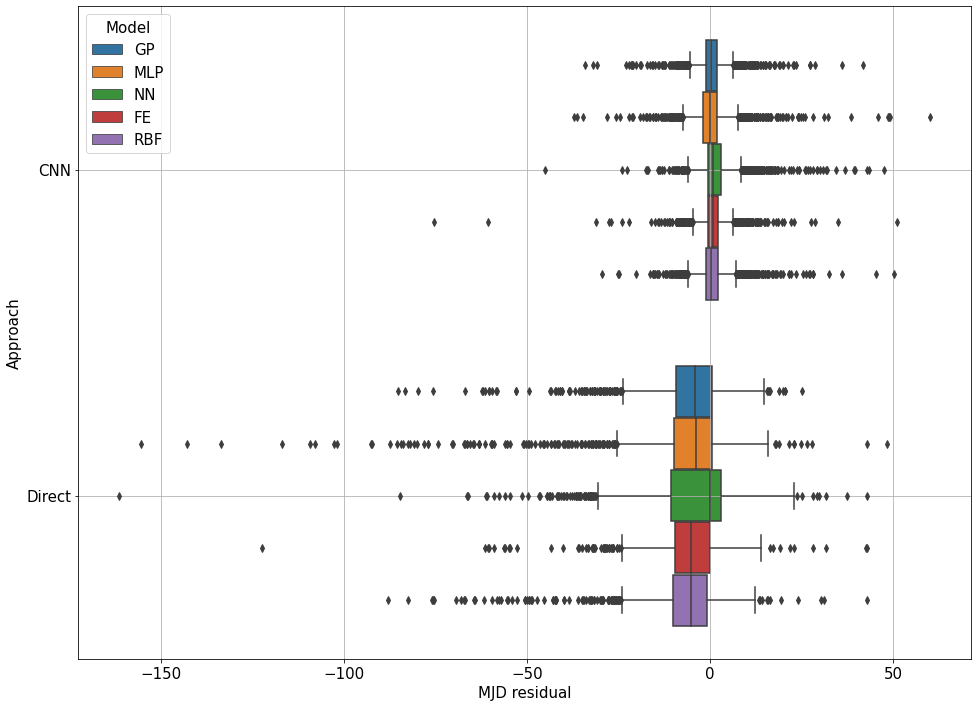

In [17]:
residual_df = pd.DataFrame()
for name, (res, direct_res) in results.items():
    residual_df['CNN-'+name] = res['true_peakmjd'] - res['pred_peakmjd']
for name, (res, direct_res) in results.items():
    residual_df['Direct-'+name] = direct_res['true_peakmjd'] - direct_res['pred_peakmjd']
residual_df = pd.melt(residual_df).rename({'variable': 'Model', 'value': 'MJD residual'}, axis=1)
residual_df['Approach'] = [x[0] for x in residual_df['Model'].str.split('-')]
residual_df['Model'] = [x[1] for x in residual_df['Model'].str.split('-')]
plt.figure(figsize=(16, 12))
sns.boxplot(data=residual_df, x='MJD residual', y='Approach', hue='Model')
plt.grid()
plt.show()

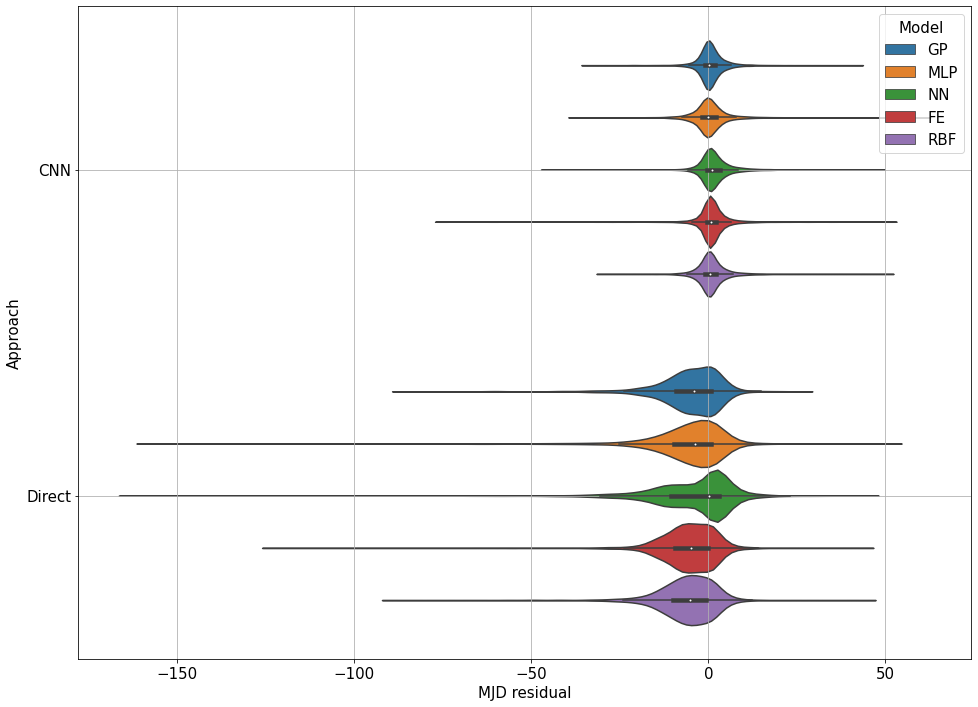

In [18]:
residual_df = pd.DataFrame()
for name, (res, direct_res) in results.items():
    residual_df['CNN-'+name] = res['true_peakmjd'] - res['pred_peakmjd']
for name, (res, direct_res) in results.items():
    residual_df['Direct-'+name] = direct_res['true_peakmjd'] - direct_res['pred_peakmjd']
residual_df = pd.melt(residual_df).rename({'variable': 'Model', 'value': 'MJD residual'}, axis=1)
residual_df['Approach'] = [x[0] for x in residual_df['Model'].str.split('-')]
residual_df['Model'] = [x[1] for x in residual_df['Model'].str.split('-')]
plt.figure(figsize=(16, 12))
sns.violinplot(data=residual_df, x='MJD residual', y='Approach', hue='Model')
plt.grid()
plt.show()